In [1]:
#!/usr/bin/env python3
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pyhf
from scipy.interpolate import interp1d

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass

### Get B2TF effs

In [2]:
b2tf_effs = np.genfromtxt('./B2TF-Trigger/JZ_numerics/b2tf_effs.csv',delimiter=',',names=True)
b2tf_data_df = pd.DataFrame(b2tf_effs,columns=b2tf_effs.dtype.names)
b2tf_data_df['dm'] = b2tf_data_df['m1']-b2tf_data_df['m0']

#### Extrapolate for small and large dm

In [3]:
new_dm = [40.0,170.0,200.0,240.0]
newRows = []
for (ms,m1,ctau),data in b2tf_data_df.groupby(['ms','m1','ctau']):
    if len(data) <= 3:
        continue
    f = interp1d(data['dm'],np.log(data['eff']),bounds_error=False,fill_value='extrapolate')
    for dm in new_dm:
        newRow = data[-1:].copy()
        if dm > newRow['m1'].min():
            continue
        newRow['dm'] = dm
        newRow['m0'] = newRow['m1']-newRow['dm']
        newRow['eff'] = max(0.0,np.exp(f(newRow['dm'])))
        newRows.append(newRow)

newRows = pd.concat(newRows)
b2tf_data_df = pd.concat((b2tf_data_df,newRows))



### Get ATLAS-EXOT-2019-23 effs

In [4]:
atlas_effs = np.genfromtxt('./ATLAS-EXOT-2019-23/atlas_exot_2019_23_effs.csv',delimiter=',',names=True)
atlas_data_df = pd.DataFrame(atlas_effs,columns=atlas_effs.dtype.names)
atlas_data_df['dm'] = atlas_data_df['m1']-atlas_data_df['m0']
# Use high-ET SR (optmistic)
atlas_data_df['eff'] = atlas_data_df['eff_highet']

### Add Cross-Sections

In [5]:
xsecsNLO = np.genfromtxt('./B2TF-Trigger/JZ_numerics/xsecsN3LO.csv',names=True,delimiter=',')
xsecList =  np.interp(b2tf_data_df['ms'], xsecsNLO['massGeV'], xsecsNLO['pp2s_N3LO_136TeVpb'])
b2tf_data_df['xsecfb'] = xsecList*1000
xsecList =  np.interp(atlas_data_df['ms'], xsecsNLO['massGeV'], xsecsNLO['pp2s_N3LO_136TeVpb'])
atlas_data_df['xsecfb'] = xsecList*1000

### Add number of signal, background and observed events

In [6]:
for df in [b2tf_data_df,atlas_data_df]:
    df['nb'] = 10.0 # From ATLAS-EXOT-2019-23 (CalRatio), Table 4
    df['nbError'] = 6.0 # From ATLAS-EXOT-2019-23 (CalRatio), Table 4
    df['nobs'] = 10.0  # Assume nobs = nb (expected)
    lumi = 139.0
    df['ns'] = df['eff']*df['xsecfb']*lumi

### Compute significance

In [7]:
b2tf_data_df['Z0'] = b2tf_data_df['ns']/np.sqrt(b2tf_data_df['nb']+b2tf_data_df['nbError']**2)
atlas_data_df['Z0'] = atlas_data_df['ns']/np.sqrt(atlas_data_df['nb']+atlas_data_df['nbError']**2)

### Compute Upper Limit

In [8]:
ns = 10.0 # dummy value to compute muUL
nb = b2tf_data_df['nb'].unique()[0]
nobs = b2tf_data_df['nobs'].unique()[0]
nbError = b2tf_data_df['nbError'].unique()[0]

model = pyhf.simplemodels.uncorrelated_background(
    signal=[ns], bkg=[nb], bkg_uncertainty=[nbError]
)
observations = [nobs]
data = pyhf.tensorlib.astensor(observations + model.config.auxdata)
scan = None
muUL_obs, _ = pyhf.infer.intervals.upper_limits.upper_limit(
    data, model, scan, return_results=False
)
ns95 = muUL_obs*ns


def getUL(dataDict):

    muUL = ns95/dataDict['ns']
    return muUL

In [9]:
b2tf_data_df['muUL'] =  b2tf_data_df[['ns','nb','nbError','nobs']].apply(getUL, axis=1,raw=False)
atlas_data_df['muUL'] =  atlas_data_df[['ns','nb','nbError','nobs']].apply(getUL, axis=1,raw=False)

/tmp/ipykernel_58826/1447473447.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  muUL = ns95/dataDict['ns']


### Plot Results: mS = 500 GeV

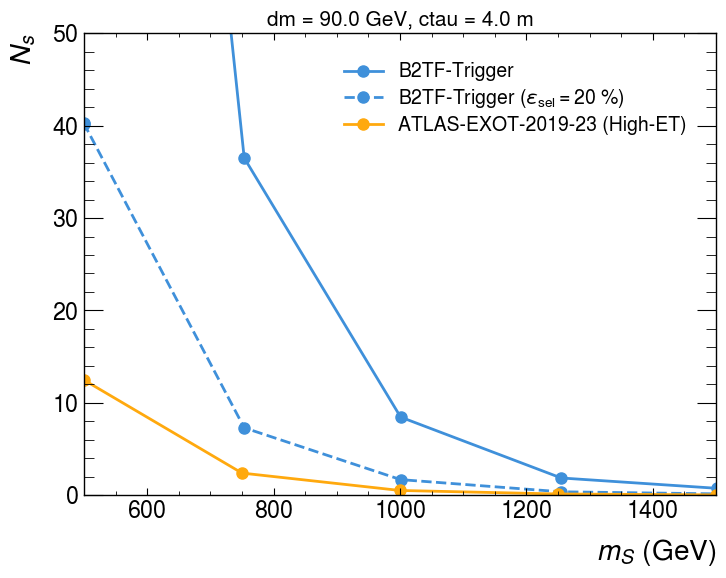

In [10]:
dm = 90.0
ctau = 4.0
effCuts = 0.2
# Filter data
b2tf_data_df_filter = b2tf_data_df[(b2tf_data_df['dm'] == dm) & (b2tf_data_df['ctau'] == ctau)]
b2tf_data_df_filter = b2tf_data_df_filter.sort_values('ms')

atlas_data_df_filter = atlas_data_df[(atlas_data_df['dm'] == dm) & (np.abs(atlas_data_df['ctau']-ctau) < 0.1)]
atlas_data_df_filter = atlas_data_df_filter.sort_values('ms')


p = plt.plot(b2tf_data_df_filter['ms'],b2tf_data_df_filter['ns'],'o-',label='B2TF-Trigger')
plt.plot(b2tf_data_df_filter['ms'],b2tf_data_df_filter['ns']*effCuts,'o--',label=r'B2TF-Trigger ($\epsilon_{\rm sel} = %1.0f$ %%)' %(100*effCuts),
         c=p[0].get_color())
plt.plot(atlas_data_df_filter['ms'],atlas_data_df_filter['ns'],'o-',label='ATLAS-EXOT-2019-23 (High-ET)')

plt.ylim(0.0,50.)
plt.xlim(500.,1500.)
# plt.yscale('log')
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$N_s$')
plt.title(f'dm = {b2tf_data_df_filter['dm'].unique()[0]} GeV, ctau = {b2tf_data_df_filter['ctau'].unique()[0]} m',fontsize=15)
plt.legend(loc='upper right')
plt.savefig('Ns_vs_ms.png')
plt.show()